In [1]:
#importing libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import imageio

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.utils import class_weight
import tensorflow as tf

In [2]:
train_dir='/kaggle/input/fer2013/facial_data/train'
val_dir='/kaggle/input/fer2013/facial_data/validation'
test_dir='/kaggle/input/fer2013/facial_data/test'

In [3]:
img_size = 48
batch_size = 128
datagen=ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
train_gen=datagen.flow_from_directory(              train_dir,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
datagen_=ImageDataGenerator(rescale=1./255)
val_gen = datagen_.flow_from_directory(val_dir,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
test_gen = datagen_.flow_from_directory(test_dir,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [4]:
model=Sequential()
# 1 - Convolution
model.add(Conv2D(32,(5,5), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=2))

# 2nd Convolution layer
model.add(Conv2D(32,(4,4), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=2))

# 3rd Convolution layer
model.add(Conv2D(64,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=2))

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

opt=keras.optimizers.SGD(learning_rate=0.01,weight_decay=0.0001,momentum=0.9,nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        16416     
                                                                 
 batch_normalization_1 (Bat  (None, 23, 23, 32)        1

In [5]:
labels=train_gen.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))

In [6]:
epoch=150
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [rlrop,checkpoint]

In [7]:
history = model.fit(
    x=train_gen,
    epochs=epoch,
    callbacks=callbacks_list,
    validation_data=val_gen,
    class_weight=class_weights
)

Epoch 1/150
225/225 [==============================] - 162s 683ms/step - loss: 2.0840 - accuracy: 0.2311 - val_loss: 1.8564 - val_accuracy: 0.3057 - lr: 0.0100
Epoch 2/150
225/225 [==============================] - 53s 234ms/step - loss: 1.8732 - accuracy: 0.3024 - val_loss: 2.2181 - val_accuracy: 0.2678 - lr: 0.0100
Epoch 3/150
225/225 [==============================] - 45s 199ms/step - loss: 1.7571 - accuracy: 0.3473 - val_loss: 1.6793 - val_accuracy: 0.3500 - lr: 0.0100
Epoch 4/150
225/225 [==============================] - 44s 197ms/step - loss: 1.6535 - accuracy: 0.3846 - val_loss: 1.8203 - val_accuracy: 0.3238 - lr: 0.0100
Epoch 5/150
225/225 [==============================] - 45s 199ms/step - loss: 1.5990 - accuracy: 0.4006 - val_loss: 1.4599 - val_accuracy: 0.4441 - lr: 0.0100
Epoch 6/150
225/225 [==============================] - 45s 200ms/step - loss: 1.5539 - accuracy: 0.4234 - val_loss: 2.0612 - val_accuracy: 0.3009 - lr: 0.0100
Epoch 7/150
225/225 [========================

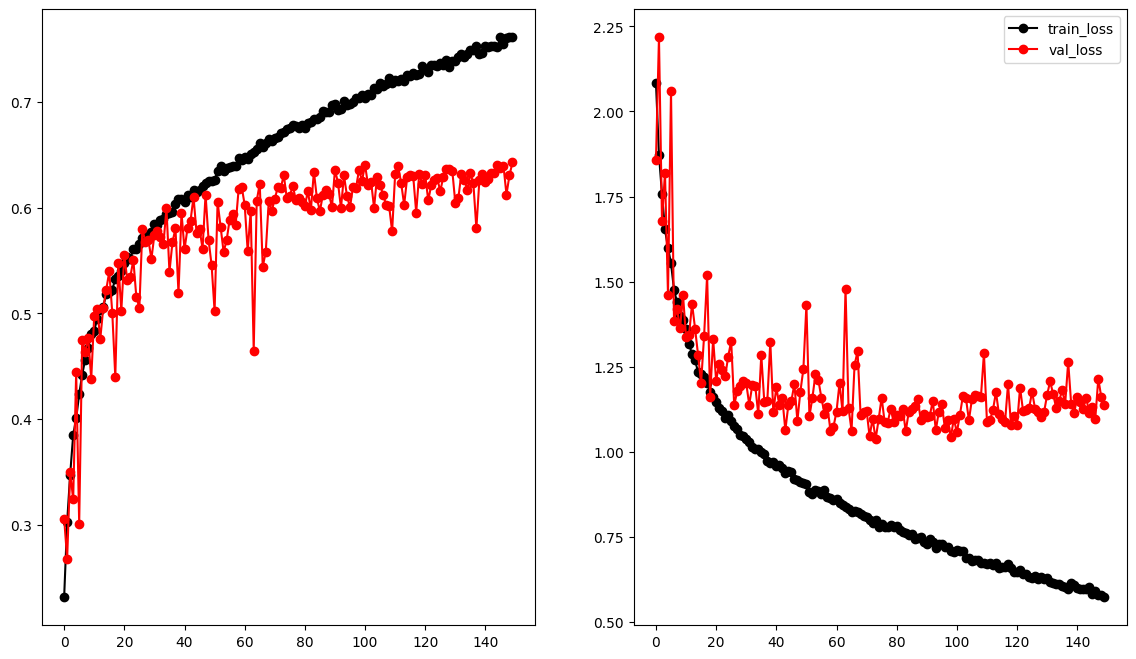

In [8]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,8))
epochs_=np.arange(150)
ax[0].plot(epochs_,history.history['accuracy'],'-o',color='black',label='train_acc')
ax[0].plot(epochs_,history.history['val_accuracy'],'-o',color='red',label='val_acc')
ax[1].plot(epochs_ , history.history['loss'] , '-o' ,color='black',label='train_loss')
ax[1].plot(epochs_ ,history.history['val_loss'] , 'r-o' ,color='red',label='val_loss')
plt.legend()

In [9]:
results_test = model.evaluate_generator(test_gen)
print('test loss, test acc:', results_test)

test loss, test acc: [1.0780307054519653, 0.6595152020454407]


In [10]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)